# Data download and preparation

In the following, we will set-up a typical data preprocessing workflow for (environmental) timeseries data. It is quite common that such data can be obtained via a web interface (REST API) and that the output from this API requires substantial reformatting and rearranging before the data can be imported into analysis or forecasting models. Typical issues encountered include:
* time series at different stations (and for different parameters) vary in length
* timeseries have some or many missing values, which are either absent from the data series or encoded as special values
* data vary in quality (some datasets may have jumps or awkward "features" that cannot be explained by natural phenomena)
* metadata to inform the data selection are missing ort difficult to access/process

In this notebook, we try to keep things relatively simple and straightforward while providing a set of tools that can also be used in more meaningful applications.

The default use case on which this notebook builds is to extract timeseries of the variable "temperature" from a handful of measurement locations, store intermediate results to avoid repeated downloads, and package the data into a single CSV file for input in the statistical analyses and ML models shown in the subsequent notebooks. The code will also run if you extract several variables at once or increase the number of stations. However, for massive data downloads, you will need to rewrite the code to be more efficient and add some monitoring of your downloads.

> Please note: In case of runtime loss or a need to run any segmented sections of the code make sure to run all the housekeeping cells before it






## Initial Setup and Data download
> This section downloads example data from TOAR for 5 stations in Germany. Refer to [TOAR Quick UserGuide](https://toar-data.fz-juelich.de/sphinx/TOAR_UG_Vol02_Quick_Start/build/html/examples.html) examples to better understand data structuring in TOAR that is used in the below snippet to download examples.

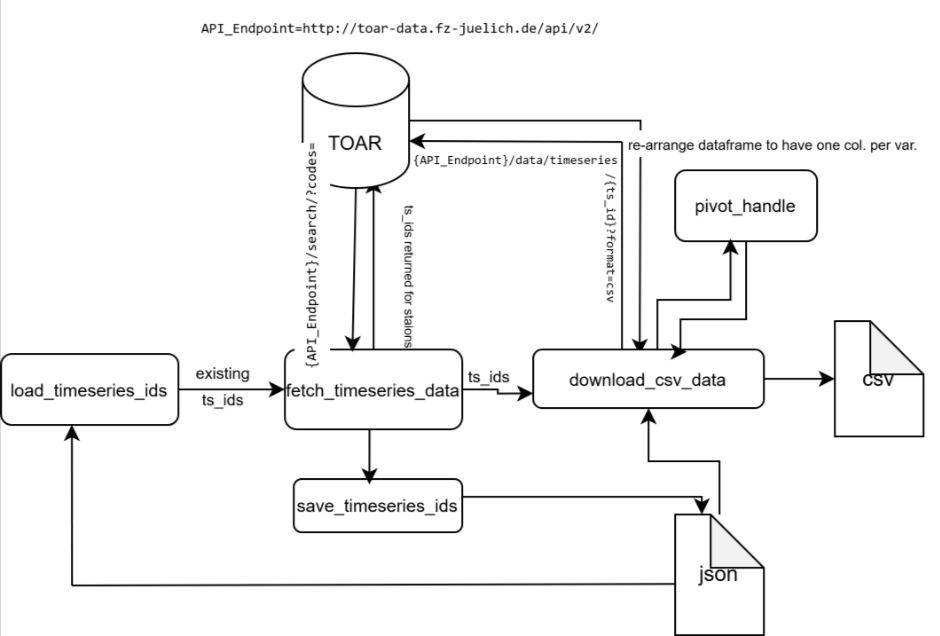

😈 **Question 1:** What are the potential challenges in working with observational environmental data?

### Housekeeping: Initial setup, declarations and method definitions

😈 **Task 1:** Explore the `station_codes` variable and try changing the station(s) to a different region.


In [ ]:
# Most notebook servers like google collab should have these packages pre-installed
# In such cases this is just a sanity check
!pip install pandas numpy requests tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl (376.0 MB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\Sindhu\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



In [ ]:
import requests
import json
import pandas as pd
import os
import csv
from datetime import datetime

# Global constants
TIMESERIES_DATA_DIR = "./content/timeseries_data/"
TIMESERIES_CSV_DIR = os.path.join(TIMESERIES_DATA_DIR, "toar_csv_timeseries")
TIMESERIES_ID_FILE = os.path.join(TIMESERIES_DATA_DIR, "timeseriesIDs.json")
MIN_FILE_SIZE_BYTES = 100
group_columns = ['station_code', 'latitude', 'longitude']

os.makedirs(TIMESERIES_DATA_DIR, exist_ok=True)
os.makedirs(TIMESERIES_CSV_DIR, exist_ok=True)

Custom range selection for experiments

station codes in the example snippet below are checked for a common range for the chosen variables, however if you prefer to experiment with ranges you might want to check using [Search API](https://toar-data.fz-juelich.de/api/v2/#search-combined-endpoint-of-stations-and-timeseries) for the date range for which data is available for a particular variable, station and source combination. As the TOAR is observational data provided via different contributing sources and has vast missing data.

😈 **Question 2:** Why might there be gaps in observational data from TOAR?


In [ ]:
# German stations with good distribution o3 variable observations
station_codes = ["DENW094", "DEBW073","DEBB029","DEBE051","DEHE020"]
# station_codes = ["DENW094"]
# variable_columns = ["no2", "temp", "o3", "no", "press"]
variable_columns = ["temp"]

Below methods each have appropriate documentation and comments to illustrate the logical flow *(they are placed with enough safeguards against both the API and optimized to avoid re-downloads when interupted during partial downloads to accomodate any loss of runtime on platforms like google colab)* and briefly described here for ease of use
>

😈 **Task 2:** Inspect the function `pivot_handle()`. What does it return, and why is pivoting important for time series analysis?


In [ ]:
def load_existing_timeseries_ids():
    """
    Load existing timeseries IDs from a JSON file.

    Returns:
        dict: A dictionary containing stored timeseries metadata.
    """
    return json.load(open(TIMESERIES_ID_FILE, 'r')) if os.path.exists(TIMESERIES_ID_FILE) else {}

def save_timeseries_ids(timeseries_data):
    """
    Save timeseries metadata to a JSON file.

    Args:
        timeseries_data (dict): A dictionary containing timeseries metadata.
    """
    json.dump(timeseries_data, open(TIMESERIES_ID_FILE, 'w'), indent=4)

def fetch_timeseries_data(station_codes, existing_timeseries, variable_columns):
    """
    Fetch timeseries metadata for given station codes, filtering by specified variables.

    Args:
        station_codes (list): List of station codes to fetch data for.
        existing_timeseries (dict): Dictionary of previously fetched timeseries metadata.
        variable_columns (list): List of variable names to retain.

    Returns:
        dict: Updated dictionary containing filtered timeseries metadata.
    """
    base_url = "http://toar-data.fz-juelich.de/api/v2/search/?codes="
    unique_entries = existing_timeseries.copy()
    processed_station_codes = {details['station_code'] for details in existing_timeseries.values()}

    for code in station_codes:
        if code in processed_station_codes:
            print(f"\t\tStation {code} is already processed, skipping.")
            continue

        response = requests.get(base_url + code, timeout=1000)
        if response.status_code == 200:
            for entry in response.json():
                if (variable_name := entry.get('variable', {}).get('name')) in variable_columns:
                    timeseries_id = entry.get('id')
                    if timeseries_id not in unique_entries:
                        unique_entries[timeseries_id] = {
                            'data_start_date': entry.get('data_start_date'),
                            'data_end_date': entry.get('data_end_date'),
                            'variable_name': variable_name,
                            'station_code': code,
                            'latitude': entry.get('station', {}).get('coordinates', {}).get('lat'),
                            'longitude': entry.get('station', {}).get('coordinates', {}).get('lng'),
                        }
        else:
            print(f"\t\tFailed to fetch data for station {code}. Status code: {response.status_code}")
    return unique_entries

def pivot_handle(dfs, metadata_columns, variable_columns):
    """
    Pivot and structure the timeseries dataframe for sequential data analysis.

    Args:
        dfs (pd.DataFrame): Dataframe containing timeseries data.
        metadata_columns (list): List of metadata column names.
        variable_columns (list): List of variable names to include.

    Returns:
        pd.DataFrame: Processed dataframe with pivoted structure.
    """
    dfs = dfs[dfs['variable_name'].isin(variable_columns)]
    pivot_df = dfs.pivot(index='datetime', columns='variable_name', values='value').reset_index()
    return dfs[metadata_columns].drop_duplicates(subset=['datetime']).merge(pivot_df, on='datetime', how='left')

def download_csv_data(timeseries_data, variable_columns):
    """
    Download and process CSV data for each timeseries ID.

    Args:
        timeseries_data (dict): Dictionary containing timeseries metadata.
        variable_columns (list): List of variable names to process.

    Returns:
        pd.DataFrame: Combined dataframe of all timeseries data.
    """
    dataframes = []
    metadata_columns = ['datetime', 'station_code', 'latitude', 'longitude']

    for ts_id, details in timeseries_data.items():
        csv_path = os.path.join(TIMESERIES_CSV_DIR, f"{ts_id}.csv")

        if os.path.exists(csv_path) and os.path.getsize(csv_path) > MIN_FILE_SIZE_BYTES:
            print(f"\tCSV already exists for timeseries ID {ts_id}, skipping download.")
        else:
            print(f"\tDownloading data for timeseries ID {ts_id}")
            url = f"http://toar-data.fz-juelich.de/api/v2/data/timeseries/{ts_id}?format=csv"
            try:
                response = requests.get(url, stream=True, timeout=1000)
                response.raise_for_status()
                with open(csv_path, 'wb') as file:
                    file.writelines(response.iter_content(chunk_size=8192))
                print(f"\t\tRaw data CSV of {ts_id} saved: {csv_path}")
            except requests.exceptions.RequestException as e:
                print(f"\t\tFailed to download data for timeseries ID {ts_id}. Error: {e}")
                continue

        try:
            df = pd.read_csv(csv_path, skiprows=lambda i: i < next(i for i, line in enumerate(open(csv_path)) if line.startswith('datetime')), low_memory=False)
            df['datetime'] = pd.to_datetime(df['datetime'], format='mixed')
            df[['variable_name', 'station_code', 'latitude', 'longitude']] = details['variable_name'], details['station_code'], details['latitude'], details['longitude']
            print(f"Dataframe for timeseries ID {ts_id} loaded successfully with shape {df.shape}")
            dataframes.append(pivot_handle(df, metadata_columns, variable_columns))
        except (pd.errors.EmptyDataError, pd.errors.ParserError) as e:
            print(f"\tError processing CSV for timeseries ID {ts_id}: {e}")
            continue

    return pd.concat(dataframes, ignore_index=True).sort_values(by=['station_code', 'datetime']) if dataframes else pd.DataFrame()

### Download via REST API

😈 **Task 3:** Try downloading a different variable or add another pollutant (e.g., `so2`). What changes?


In [ ]:
# Load existing timeseries IDs from json to skip calls to TOAR
existing_timeseries = load_existing_timeseries_ids()

timeseries_data = fetch_timeseries_data(station_codes, existing_timeseries,variable_columns)
print(f"\t Number of time series meta data fetched : {len(timeseries_data)}")

# save existing timeseries IDs as json to reduce calls to TOAR in future
save_timeseries_ids(timeseries_data)

dataframes = download_csv_data(timeseries_data,variable_columns)
print(f"\t Total dataFrames processed : {len(dataframes)} and shape of first dataframe {dataframes.shape}.")

dataframes.head()

	 Number of time series meta data fetched : 3
		Raw data CSV of 76 saved: ./content/timeseries_data/toar_csv_timeseries\76.csv
Dataframe for timeseries ID 76 loaded successfully with shape (245580, 9)
		Raw data CSV of 22639 saved: ./content/timeseries_data/toar_csv_timeseries\22639.csv
Dataframe for timeseries ID 22639 loaded successfully with shape (110890, 9)
		Raw data CSV of 18022 saved: ./content/timeseries_data/toar_csv_timeseries\18022.csv
Dataframe for timeseries ID 18022 loaded successfully with shape (219901, 9)
	 Total dataFrames processed : 576371 and shape of first dataframe (576371, 5).


,datetime,station_code,latitude,longitude,temp
245580,1997-01-01 00:00:00+00:00,DEBW073,47.819182,7.567796,-10.0
245581,1997-01-01 01:00:00+00:00,DEBW073,47.819182,7.567796,-11.0
245582,1997-01-01 02:00:00+00:00,DEBW073,47.819182,7.567796,-11.0
245583,1997-01-01 03:00:00+00:00,DEBW073,47.819182,7.567796,-12.0
245584,1997-01-01 04:00:00+00:00,DEBW073,47.819182,7.567796,-12.0


As the TOAR is observational data provided via different contributing sources and has vast missing data, we expect the NAs despite finding a common date range and need to check how many missing values (NAs) there are for each variable.

## Data handling (observational gaps)

Once we know that, we can figure out the best way to fill in the gaps, like using interpolation or making the data more consistent. In our case as the data is towards pollutant concentration and data is hourly, we can safely fill a consecutive 6 hour window without compromising the quality of the data

😈 **Question 3:** Why is it acceptable to fill up to 6 missing hourly values in this dataset?


In [ ]:
import numpy as np
def fill_six_nans(group):
    """
    Fills up to six consecutive NaN values in a given pandas Series using linear interpolation
    if the NaNs are surrounded by valid values. If the NaNs are at the start, they are replaced
    with zeros, and if they are at the end, they are filled with the last known value.

    Args:
        group (pd.Series): The input Series with potential NaN values.

    Returns:
        pd.Series: A Series where up to six consecutive NaNs are interpolated, and longer NaN
        sequences are partially filled while preserving the original index.
    """
    values = group.to_numpy()
    i = 0
    while i < len(values):
        if np.isnan(values[i]):
            start = i
            while i < len(values) and np.isnan(values[i]):
                i += 1
            end = min(i, start + 6)  # Limit to filling only 6 NaNs

            if start > 0 and i < len(values):  # NaNs in the middle
                fill_values = np.linspace(values[start - 1], values[i], end - start + 2)[1:-1]
            elif start == 0:  # NaNs at the start
                fill_values = [0] * (end - start)
            elif i >= len(values):  # NaNs at the end
                fill_values = [values[start - 1]] * (end - start)
            values[start:end] = fill_values
        else:
            i += 1
    return pd.Series(values, index=group.index)

In [ ]:
dataframes[variable_columns] = dataframes.groupby(group_columns)[variable_columns].transform(fill_six_nans)
dataframes.isna().sum()

datetime        0
station_code    0
latitude        0
longitude       0
temp            0
dtype: int64

Now rest of the Nas can be dropped as that station might not have data collected in the time period and the data needs to be normalized.

😈 **Task 4:** What risks might arise if normalization is applied *before* handling missing values?


In [ ]:
dataframes = dataframes.dropna()
dataframes.isna().sum()

datetime        0
station_code    0
latitude        0
longitude       0
temp            0
dtype: int64

In [ ]:
dataframes.shape

(576371, 5)

## Staged data loading (Housekeeping)

To proceed with any analysis now the normalized data can be reloaded from local when needed (In case of runtime losses) to continue with ML experiments rather than re-downloading and normalizing again.

😈 **Task 5:** Modify this section to reload data from a custom path or add a parameter to toggle reloading.


In [ ]:
dataframes.to_csv(os.path.join(TIMESERIES_DATA_DIR, "raw_data.csv"), index=False)

Below cell can be used to reload data if using an open source notebook servers like google colab and the if the usage limit is reached or for other issues

In [ ]:
import pandas as pd
import os

## Normalized data csv is also made available for the select stations in URL:
# https://drive.google.com/file/d/1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq/view?usp=drive_link
dataframes = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "raw_data.csv"))
dataframes.head()

,datetime,station_code,latitude,longitude,temp
0,1997-01-01 00:00:00+00:00,DEBW073,47.819182,7.567796,-10.0
1,1997-01-01 01:00:00+00:00,DEBW073,47.819182,7.567796,-11.0
2,1997-01-01 02:00:00+00:00,DEBW073,47.819182,7.567796,-11.0
3,1997-01-01 03:00:00+00:00,DEBW073,47.819182,7.567796,-12.0
4,1997-01-01 04:00:00+00:00,DEBW073,47.819182,7.567796,-12.0


In [ ]:
dataframes.shape

(576371, 5)

In [ ]:
dataframes.isna().sum()

datetime        0
station_code    0
latitude        0
longitude       0
temp            0
dtype: int64

### Statistical Analysis

The data can now be analysed for basic statistical tendencies or measures like (note standard measures are indicated here, but you can run custom measures as well)

😈 **Task 6:** Create a boxplot for `no2` and `o3` by station to visualize spread and outliers.

😈 **Question 4:** Which station shows the highest variance in `no2`? What might explain this?


In [ ]:
stats = ['min', 'max', 'mean', 'sum', 'std', 'var', 'median','prod','nunique',
    ('5th_percentile', lambda x: x.quantile(0.05)),
    ('10th_percentile', lambda x: x.quantile(0.10)),
    ('25th_percentile', lambda x: x.quantile(0.25)),
    ('50th_percentile', lambda x: x.quantile(0.50)), #(median)
    ('75th_percentile', lambda x: x.quantile(0.75))]
agg_dict = {col: stats for col in variable_columns}
grouped = dataframes.groupby('station_code').agg(agg_dict)
display(grouped)

for agg_func in ['min', 'max', 'mean', 'std']:
    display(agg_func)
    agg_view = grouped.xs(agg_func, axis=1, level=1)
    display(agg_view)

temp                                                           \
                min        max       mean           sum       std        var   
station_code                                                                   
DEBW073      -14.50  37.300000  11.009674  1.220863e+06  8.172790  66.794496   
DEHE020      -18.20  38.842102  10.709302  2.354986e+06  8.084842  65.364675   
DENW094      -17.95  39.126000  10.557351  2.592674e+06  7.280404  53.004277   

                                                                    \
                median prod nunique 5th_percentile 10th_percentile   
station_code                                                         
DEBW073       11.00000 -0.0     968          -2.00        0.200000   
DEHE020       10.24515 -0.0   95966          -1.40        0.643705   
DENW094       10.28400  NaN   50737          -0.79        1.265000   

                                                              
             25th_percentile 50th_percentile 75th_percentile  
station_code                                                  
DEBW073             5.000000        11.00000            16.8  
DEHE020             4.642115        10.24515            16.4  
DENW094             5.279750        10.28400            15.5

'min'

,temp
station_code,
DEBW073,-14.50
DEHE020,-18.20
DENW094,-17.95


'max'

,temp
station_code,
DEBW073,37.300000
DEHE020,38.842102
DENW094,39.126000


'mean'

,temp
station_code,
DEBW073,11.009674
DEHE020,10.709302
DENW094,10.557351


'std'

,temp
station_code,
DEBW073,8.172790
DEHE020,8.084842
DENW094,7.280404


## Data Preprocessing (Normalization)

the snippet below uses standard Z normalization (this is a simple snippet alternatively other approaches could also be used as desired)


😈 **Task 7:** Implement min-max normalization and compare the results visually with Z-score.


In [ ]:
def standard_scaler(df, columns):
    """
    Standardize the specified columns of a DataFrame by subtracting the mean
    and dividing by the standard deviation (Z-score normalization).

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to be normalized.

    Returns:
        pd.DataFrame: DataFrame with normalized columns.
    """
    df_scaled = df.copy()
    for col in columns:
        mean = df_scaled[col].mean()
        std = df_scaled[col].std()
        df_scaled[col] = (df_scaled[col] - mean) / std
    return df_scaled

In [ ]:
dataframes = standard_scaler(dataframes, variable_columns)
dataframes.head()

,datetime,station_code,latitude,longitude,temp
0,1997-01-01 00:00:00+00:00,DEBW073,47.819182,7.567796,-2.663793
1,1997-01-01 01:00:00+00:00,DEBW073,47.819182,7.567796,-2.792464
2,1997-01-01 02:00:00+00:00,DEBW073,47.819182,7.567796,-2.792464
3,1997-01-01 03:00:00+00:00,DEBW073,47.819182,7.567796,-2.921135
4,1997-01-01 04:00:00+00:00,DEBW073,47.819182,7.567796,-2.921135


In [ ]:
dataframes.to_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"), index=False)

In [ ]:
import pandas as pd
import os

## Normalized data csv is also made available for the select stations in URL:
# https://drive.google.com/file/d/1Eui59GyTXNv839WijdZ0CkzuMubmZQz1/view?usp=drive_link
# or if run locally you can load from the path as below:
# e.g. r"./content/timeseries_data/normalized_data.csv"
dataframes = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"))
dataframes.head()

,datetime,station_code,latitude,longitude,temp
0,1997-01-01 00:00:00+00:00,DEBW073,47.819182,7.567796,-2.663793
1,1997-01-01 01:00:00+00:00,DEBW073,47.819182,7.567796,-2.792464
2,1997-01-01 02:00:00+00:00,DEBW073,47.819182,7.567796,-2.792464
3,1997-01-01 03:00:00+00:00,DEBW073,47.819182,7.567796,-2.921135
4,1997-01-01 04:00:00+00:00,DEBW073,47.819182,7.567796,-2.921135


### (Optional/Advanced) Multi-Variable Case:

We've seen how to download one variable for multiple stations. Now let's try and download multi-variables for one station.  

- You know the drill at this point:
  - Set the paths for loading the timeseries_ids(unique to each variable) corresponding to the station code and downloading timeseries data for all the variables.
  - Fetch the variables for the station of interest
  - Fill the gaps upto 6hrs
  - Drop NAs
  - Log transformation after checking for skewdness(additional)
  - Z-score Normalization

In [ ]:
import requests
import json
import pandas as pd
import os
import csv
from datetime import datetime

# Global constants
TIMESERIES_DATA_DIR = "./content/timeseries_multivariate_data/"
TIMESERIES_CSV_DIR = os.path.join(TIMESERIES_DATA_DIR, "toar_csv_timeseries")
TIMESERIES_ID_FILE = os.path.join(TIMESERIES_DATA_DIR, "timeseriesIDs.json")
MIN_FILE_SIZE_BYTES = 100
group_columns = ['station_code', 'latitude', 'longitude']

os.makedirs(TIMESERIES_DATA_DIR, exist_ok=True)
os.makedirs(TIMESERIES_CSV_DIR, exist_ok=True)

#### Fetch the variables

In [ ]:
# German stations with good distribution o3 variable observations
station_codes = ["DENW094"]
variable_columns = ["no2", "temp", "o3", "no", "press"]


</details>

#### Download the variables data for that 1 station via REST API

In [ ]:
# Load existing timeseries IDs from json to skip calls to TOAR
existing_timeseries = load_existing_timeseries_ids()

timeseries_data = fetch_timeseries_data(station_codes, existing_timeseries,variable_columns)
print(f"\t Number of time series meta data fetched : {len(timeseries_data)}")

# save existing timeseries IDs as json to reduce calls to TOAR in future
save_timeseries_ids(timeseries_data)

dataframes = download_csv_data(timeseries_data,variable_columns)
print(f"\t Total dataFrames processed : {len(dataframes)} and shape of first dataframe {dataframes.shape}.")

dataframes.head()

	 Number of time series meta data fetched : 5
		Raw data CSV of 73 saved: ./content/timeseries_multivariate_data/toar_csv_timeseries/73.csv
Dataframe for timeseries ID 73 loaded successfully with shape (210341, 9)
		Raw data CSV of 74 saved: ./content/timeseries_multivariate_data/toar_csv_timeseries/74.csv
Dataframe for timeseries ID 74 loaded successfully with shape (209420, 9)
		Raw data CSV of 75 saved: ./content/timeseries_multivariate_data/toar_csv_timeseries/75.csv
Dataframe for timeseries ID 75 loaded successfully with shape (207900, 9)
		Raw data CSV of 76 saved: ./content/timeseries_multivariate_data/toar_csv_timeseries/76.csv
Dataframe for timeseries ID 76 loaded successfully with shape (245635, 9)
		Raw data CSV of 80 saved: ./content/timeseries_multivariate_data/toar_csv_timeseries/80.csv
Dataframe for timeseries ID 80 loaded successfully with shape (160608, 9)
	 Total dataFrames processed : 1033904 and shape of first dataframe (1033904, 9).


,datetime,station_code,latitude,longitude,o3,no2,no,temp,press
627661,1997-01-01 00:00:00+00:00,DENW094,50.754704,6.093923,NaN,NaN,NaN,-15.85,NaN
627662,1997-01-01 01:00:00+00:00,DENW094,50.754704,6.093923,NaN,NaN,NaN,-16.35,NaN
627663,1997-01-01 02:00:00+00:00,DENW094,50.754704,6.093923,NaN,NaN,NaN,-16.45,NaN
627664,1997-01-01 03:00:00+00:00,DENW094,50.754704,6.093923,NaN,NaN,NaN,-17.15,NaN
627665,1997-01-01 04:00:00+00:00,DENW094,50.754704,6.093923,NaN,NaN,NaN,-17.35,NaN


#### Data handling (observational gaps)

##### Filling up upto 6 NAs

In [ ]:
dataframes[variable_columns] = dataframes.groupby(group_columns)[variable_columns].transform(fill_six_nans)
dataframes.isna().sum()

,0
datetime,0
station_code,0
latitude,0
longitude,0
o3,50326
no2,44988
no,50485
temp,3521
press,267319


##### After dropping NAs

In [ ]:
dataframes = dataframes.dropna()
dataframes.isna().sum()

,0
datetime,0
station_code,0
latitude,0
longitude,0
o3,0
no2,0
no,0
temp,0
press,0


#### Statistical Analysis

In [ ]:
stats = ['min', 'max', 'mean', 'sum', 'std', 'var', 'median','prod','nunique',
    ('5th_percentile', lambda x: x.quantile(0.05)),
    ('10th_percentile', lambda x: x.quantile(0.10)),
    ('25th_percentile', lambda x: x.quantile(0.25)),
    ('50th_percentile', lambda x: x.quantile(0.50)), #(median)
    ('75th_percentile', lambda x: x.quantile(0.75))]
agg_dict = {col: stats for col in variable_columns}
grouped = dataframes.groupby('station_code').agg(agg_dict)
display(grouped)

for agg_func in ['min', 'max', 'mean', 'std']:
    display(agg_func)
    agg_view = grouped.xs(agg_func, axis=1, level=1)
    display(agg_view)

no2                                               \
                   min        max      mean           sum       std   
station_code                                                          
DENW094      -2.544249  81.321835  7.574944  5.324383e+06  6.359106   

                                                               ...     press  \
                    var    median prod nunique 5th_percentile  ...       std   
station_code                                                   ...             
DENW094       40.438231  5.648024 -0.0  294000       1.250368  ...  9.809127   

                                                                 \
                    var      median prod nunique 5th_percentile   
station_code                                                      
DENW094       96.218972  993.193265  0.0  173348     975.436169   

                                                                              
             10th_percentile 25th_percentile 50th_percentile 75th_percentile  
station_code                                                                  
DENW094                980.0      987.048013      993.193265      998.912165  

[1 rows x 70 columns]

'min'

,no2,temp,o3,no,press
station_code,,,,,
DENW094,-2.544249,-17.35,-1.417507,-3.360428,0.0


'max'

,no2,temp,o3,no,press
station_code,,,,,
DENW094,81.321835,39.126,134.83356,447.81647,1023.717


'mean'

,no2,temp,o3,no,press
station_code,,,,,
DENW094,7.574944,10.681479,24.706104,3.301909,992.486596


'std'

,no2,temp,o3,no,press
station_code,,,,,
DENW094,6.359106,7.438985,14.647992,8.883813,9.809127


#### Log Scaling after checking for skewdness

In [ ]:
import numpy as np
from scipy.stats import skew

def log_transform_if_skewed(df, columns, threshold=1.0):
    """
    Log-transform the specified columns of a DataFrame based on their skewdness.

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names that need to be checked for skewdness.

    Returns:
        pd.DataFrame: DataFrame with normalized columns.
    """
    df_transformed = df.copy()

    for col in columns:
        # s = df[col].dropna()
        s = df[col]
        current_skewness = skew(s)

        print(f"[{col}] Skewness: {current_skewness:.2f}")

        if abs(current_skewness) > threshold:
            # To avoid log(0) or log(negative values).
            if (s <= 0).any():
                shift = abs(s.min()) + 1e-6
                print(f"Applying log(x + {shift:.6f}) to {col}")
                df_transformed[col] = np.log(df[col] + shift)
            else:
                print(f"Applying log(x) to {col}")
                df_transformed[col] = np.log(df[col])
        else:
            print(f"No transformation applied to {col}.")

    return df_transformed

In [ ]:
dataframe_= log_transform_if_skewed(dataframes, variable_columns, threshold=1.0)
dataframe_.head()

[no2] Skewness: 1.66
Applying log(x + 2.544250) to no2
[temp] Skewness: 0.21
No transformation applied to temp.
[o3] Skewness: 0.64
No transformation applied to o3.
[no] Skewness: 8.75
Applying log(x + 3.360429) to no
[press] Skewness: -9.32
Applying log(x + 0.000001) to press


,datetime,station_code,latitude,longitude,o3,no2,no,temp,press
627661,1997-01-01 00:00:00+00:00,DENW094,50.754704,6.093923,0.0,0.933836,1.212069,-15.85,-13.815511
627662,1997-01-01 01:00:00+00:00,DENW094,50.754704,6.093923,0.0,0.933836,1.212069,-16.35,-13.815511
627663,1997-01-01 02:00:00+00:00,DENW094,50.754704,6.093923,0.0,0.933836,1.212069,-16.45,-13.815511
627664,1997-01-01 03:00:00+00:00,DENW094,50.754704,6.093923,0.0,0.933836,1.212069,-17.15,-13.815511
627665,1997-01-01 04:00:00+00:00,DENW094,50.754704,6.093923,0.0,0.933836,1.212069,-17.35,-13.815511


#### Normalize the data

😈 Task 8: Why do we need both log transformation and Z-score normalization?

In [ ]:
dataframes = standard_scaler(dataframe_, variable_columns)
dataframes.head()

,datetime,station_code,latitude,longitude,o3,no2,no,temp,press
627661,1997-01-01 00:00:00+00:00,DENW094,50.754704,6.093923,-1.686655,-2.140869,-0.757711,-3.566546,-338.156439
627662,1997-01-01 01:00:00+00:00,DENW094,50.754704,6.093923,-1.686655,-2.140869,-0.757711,-3.633759,-338.156439
627663,1997-01-01 02:00:00+00:00,DENW094,50.754704,6.093923,-1.686655,-2.140869,-0.757711,-3.647202,-338.156439
627664,1997-01-01 03:00:00+00:00,DENW094,50.754704,6.093923,-1.686655,-2.140869,-0.757711,-3.741301,-338.156439
627665,1997-01-01 04:00:00+00:00,DENW094,50.754704,6.093923,-1.686655,-2.140869,-0.757711,-3.768186,-338.156439


##### Save the normalized dataframe for later use

In [ ]:
dataframes.to_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"), index=False)

##### If you want the normalized data directly, then you could just download from the drive.

In [ ]:
import pandas as pd
import os

## Normalized data csv is also made available for the select stations in URL:
# https://drive.google.com/file/d/1Eui59GyTXNv839WijdZ0CkzuMubmZQz1/view?usp=drive_link
# or if run locally you can load from the path as below:
# e.g. r"./content/timeseries_data/normalized_data.csv"
dataframes = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"))
dataframes.head()

,datetime,station_code,latitude,longitude,o3,no2,no,temp,press
0,1997-01-01 00:00:00+00:00,DENW094,50.754704,6.093923,-1.686655,-2.140869,-0.757711,-3.566546,-338.156439
1,1997-01-01 01:00:00+00:00,DENW094,50.754704,6.093923,-1.686655,-2.140869,-0.757711,-3.633759,-338.156439
2,1997-01-01 02:00:00+00:00,DENW094,50.754704,6.093923,-1.686655,-2.140869,-0.757711,-3.647202,-338.156439
3,1997-01-01 03:00:00+00:00,DENW094,50.754704,6.093923,-1.686655,-2.140869,-0.757711,-3.741301,-338.156439
4,1997-01-01 04:00:00+00:00,DENW094,50.754704,6.093923,-1.686655,-2.140869,-0.757711,-3.768186,-338.156439
